Image segmentation with pytorch? (about 15 minutes for tutorial)

In an image classification task the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case you will want to assign a class to each pixel of the image. This task is known as segmentation. A segmentation model returns much more detailed intofmation about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

## Context

> CamSeq01 is a groundtruth dataset that can be freely used for research work in object recognition in video.


## Content

> This dataset contains 101 960x720 pixel image pairs. Every mask is designated by an "_L" addition to the file name. All images (original and groundtruth) are in uncompressed 24-bit color PNG format.


## Citation

> Julien Fauqueur, Gabriel Brostow, Roberto Cipolla, Assisted Video Object Labeling By Joint Tracking of Regions and Keypoints, IEEE International Conference on Computer Vision (ICCV'2007) Interactive Computer Vision Workshop. Rio de Janeiro, Brazil, October 2007


## Kaggle URL

> https://www.kaggle.com/datasets/carlolepelaars/camseq-semantic-segmentation


> Modified (24/01/2025) from: https://www.kaggle.com/code/erelin6613/sample-deeplabv3-for-segmentation





In [2]:
# download the dataset from kaggle link above or use this script
! wget https://github.com/pvateekul/2110531_DSDE_2023s1/raw/main/code/Week05_Intro_Deep_Learning/data/Camseq_2007.zip

--2025-02-09 01:40:09--  https://github.com/pvateekul/2110531_DSDE_2023s1/raw/main/code/Week05_Intro_Deep_Learning/data/Camseq_2007.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/pvateekul/2110531_DSDE_2023s1/main/code/Week05_Intro_Deep_Learning/data/Camseq_2007.zip [following]
--2025-02-09 01:40:09--  https://media.githubusercontent.com/media/pvateekul/2110531_DSDE_2023s1/main/code/Week05_Intro_Deep_Learning/data/Camseq_2007.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94571829 (90M) [application/zip]
Saving to: ‘Camseq_2007.zip.1’

Camseq_2007.zip.1   100%[=========

In [3]:
# install required libs
! pip install torchinfo

In [4]:
# check gpu available if not : goto tool-bar -> runtime -> change runtime types -> Hardware accelerator = GPU
! nvidia-smi

Sun Feb  9 01:40:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device-> cuda:{device's number}

print(device)

cuda:0


In [6]:
#  unzip file (-q : quiet mode)
! unzip -FF Camseq_2007.zip

Archive:  Camseq_2007.zip
replace Camseq_2007/0016E5_07959.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
!pip install pytorch-lightning

# Dataset structure for Camseq_2007:
```
contains 204 files = 101 images, 101 label, 1 colormap.txt, 1 readme.txt
Camseq_2007/
  0016E5_07959.png
  0016E5_07959_L.png (label file or called mask)
  ...
  0016E5_08159.png
  0016E5_08159_L.png
  label_colors.txt
  readme.txt

```

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary as summary_info
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

# utils
import os
import numpy as np
from collections import OrderedDict
from itertools import islice

# Transformation
import albumentations as A
from albumentations.pytorch import ToTensorV2

from collections import OrderedDict

# Visualization
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Progress bar
from tqdm.notebook import tqdm

%matplotlib inline
torch.__version__

'2.5.1+cu124'

## Dataset

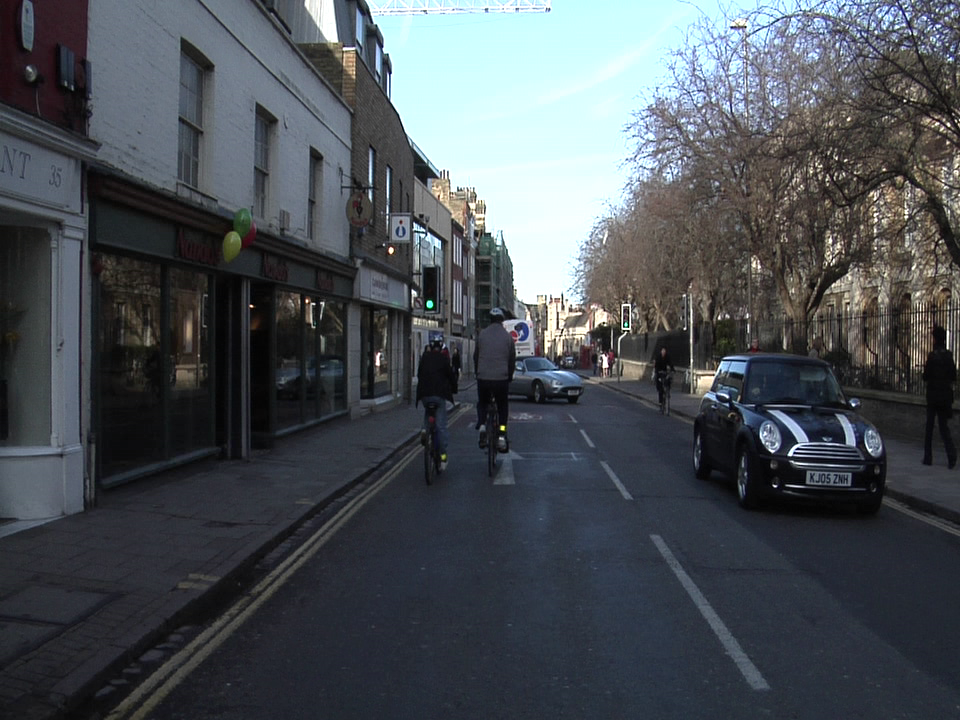

In [9]:
# input image
img = Image.open('./Camseq_2007/0016E5_07961.png')
img

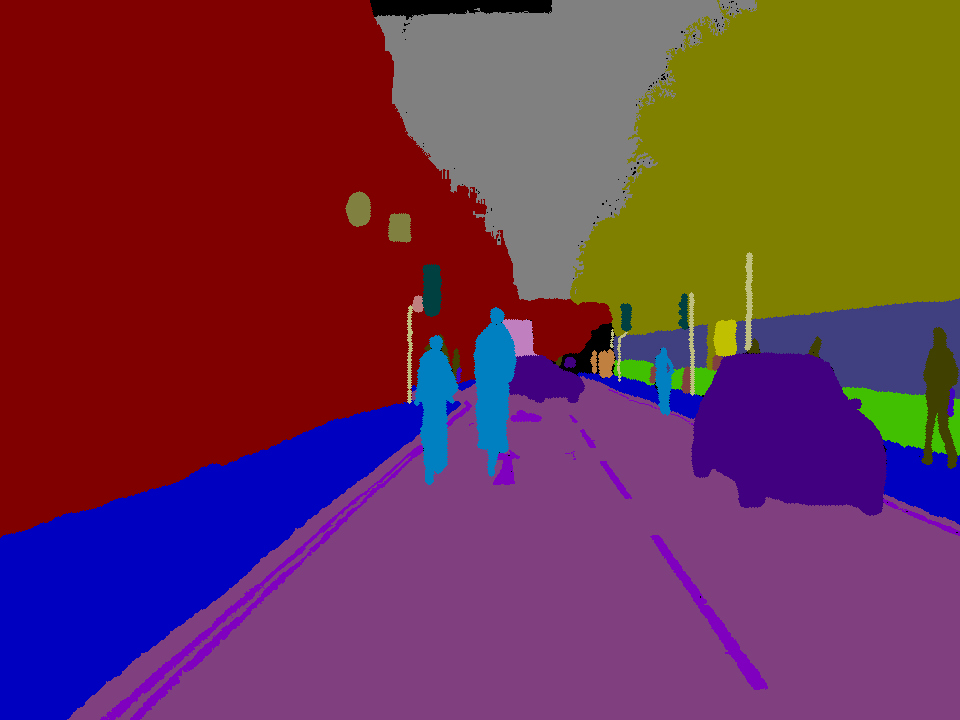

In [10]:
# input mask
img = Image.open('./Camseq_2007/0016E5_07961_L.png')
img

In [11]:
# The mask has only four values but many colors because the colormap is created by combining the four values. (0, 64, 128, 192)
np.unique(np.array(img)[:,:,1])

array([  0,  64, 128, 192], dtype=uint8)

# Colormap example ( [R, G, B] )
```
  'Animal': [64, 128, 64],
  'Archway': [192, 0, 128],
  'Bicyclist': [0, 128, 192],
  'Bridge': [0, 128, 64],
  'Building': [128, 0, 0],
  'Car': [64, 0, 128],
  'CartLuggagePram': [64, 0, 192],
  'Child': [192, 128, 64],
```

In [12]:
# load colormap from label_colors.txt
colormap = OrderedDict()
with open("./Camseq_2007/label_colors.txt",'r') as f:
    for line in f:
        r,g,b,cls = line.split()
        colormap[cls] = [int(e) for e in [r,g,b]]
list(islice(colormap.items(),8))

[('Animal', [64, 128, 64]),
 ('Archway', [192, 0, 128]),
 ('Bicyclist', [0, 128, 192]),
 ('Bridge', [0, 128, 64]),
 ('Building', [128, 0, 0]),
 ('Car', [64, 0, 128]),
 ('CartLuggagePram', [64, 0, 192]),
 ('Child', [192, 128, 64])]

In [13]:
class CamSeqDataset(Dataset):

    def __init__(self,
                 img_dir,
                 colormap=colormap,
                 transforms=None):

        super().__init__()
        # sort order of frame from video sequence
        self.images = sorted([os.path.join(img_dir, e)
                              for e in os.listdir(img_dir)
                              if not e.split('.')[0].endswith('_L')])
        # remove text files
        self.images = [e for e in self.images if not e.endswith('.txt')]
        self.masks = sorted([os.path.join(img_dir, e)
                              for e in os.listdir(img_dir)
                              if e.split('.')[0].endswith('_L')])
        self.colormap = colormap
        self.num_classes = len(self.colormap) # 32 classes
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        img = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])

        if img.mode != 'RGB':
            img = img.convert('RGB')
        if mask.mode != 'RGB':
            mask = mask.convert('RGB')

        img = np.asarray(img) # change from image to array
        mask = np.asarray(mask)
        mask_channels = np.zeros(
            (mask.shape[0], mask.shape[1]), dtype=np.int64)

        # convert RGB mask to class-pixel mask ; (R,G,B) -> (Class)
        for i, cls in enumerate(self.colormap.keys()):
            color = self.colormap[cls]
            sub_mask = np.all(mask==color, axis=-1)*i
            mask_channels += sub_mask #*i

        # transforms such as normalization
        if self.transforms is not None:
            transformed = self.transforms(image=img, masks=mask_channels)
            img = transformed['image']
            mask_channels = transformed['masks']

        mask_channels = mask_channels.astype(np.float32)
        img = img.astype(np.float32) #/255

        instance = {'image': torch.from_numpy(img.transpose(2,0,1)),
                    'mask': torch.from_numpy(mask_channels)}

        return instance

    def ___first__(self):
        return self.__getitem__[0]

In [14]:
# simple transform (using ImageNet norm and std) "Albumentation == torchvision.transforms for segmentation"
transform = A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [15]:
dataset = CamSeqDataset(img_dir='./Camseq_2007', colormap=colormap,transforms=transform)
# we split train/val/test -> 70/15/15
train_size = int(len(dataset)*0.7)
val_size = (len(dataset)-train_size)//2
# train_set, rest = random_split(dataset, [train_size, len(dataset)-train_size])
# val_set, test_set = random_split(rest, [val_size, len(rest)-val_size])
# We do not use random split because the dataset is extracted from a video sequence, so nearly every frame looks the same.
train_set = Subset(dataset, range(train_size))
val_set = Subset(dataset, range(train_size, train_size + val_size))
test_set = Subset(dataset, range(train_size + val_size, len(dataset)))


In [16]:
batch_size = 2

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [17]:
# loader size : 101 images (train/val/test) -> (70/16/15) -> batch size 2 (35/8/8)
len(train_loader), len(val_loader), len(test_loader)

(35, 8, 8)

## Training

In [18]:
class deeplabv3(pl.LightningModule):
    def __init__(self, out_channels=32):
        super().__init__()
        # Load model
        self.model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
    # decoder head
        self.model.classifier = torchvision.models.segmentation.deeplabv3.DeepLabHead(
                                2048, num_classes=out_channels)
        self.model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = 0.0002
        self.train_metrics = []
        self.val_metrics = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs = batch['image'].to(device)
        masks = batch['mask'].to(device)

        outputs = self.model(inputs)
        y_pred = outputs['out']
        y_true = masks
        loss = self.criterion(y_pred.float(), y_true.long())
        acc = (torch.argmax(y_pred, 1) == y_true).float().mean()

        # Log metrics
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        # Collect epoch metrics
        train_loss = self.trainer.callback_metrics["train_loss"]
        train_acc = self.trainer.callback_metrics["train_acc"]
        self.train_metrics.append(
            {
                "epoch": self.current_epoch,
                "train_loss": train_loss.item(),
                "train_acc": train_acc.item(),
            }
        )

    def validation_step(self, batch, batch_idx):
        inputs = batch['image'].to(device)
        masks = batch['mask'].to(device)
        with torch.no_grad():
            outputs = self.model(inputs)
        y_pred = outputs['out']
        y_true = masks
        loss = self.criterion(y_pred.float(), y_true.long())
        # acc using pixel accuracy. (it is easy to understand,but no way the best metric)
        # learn more https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
        acc = (torch.argmax(y_pred, 1) == y_true).float().mean()

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_validation_epoch_end(self):
        # Update validation metrics
        val_loss = self.trainer.callback_metrics["val_loss"]
        val_acc = self.trainer.callback_metrics["val_acc"]
        self.val_metrics.append(
            {
                "val_loss": val_loss.item(),
                "val_acc": val_acc.item(),
            }
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

net = deeplabv3(out_channels=32).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",       # Monitor validation accuracy
    mode="max",              # Save the model with the highest accuracy
    save_top_k=5,            # Save only the best model
    filename="best-acc-{epoch:02d}-{val_acc:.4f}",  # File name format
    verbose=True             # Print messages when saving
)

In [20]:
trainer = pl.Trainer(max_epochs=5, callbacks=[checkpoint_callback])
trainer.fit(net, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | DeepLabV3        | 42.0 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
42.0 M    Trainable params
0         Non-trainable params
42.0 M    Total params
168.028   Total estimated model params size (MB)
190       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 35: 'val_acc' reached 0.88233 (best 0.88233), saving model to '/content/lightning_logs/version_1/checkpoints/best-acc-epoch=00-val_acc=0.8823.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 70: 'val_acc' reached 0.90271 (best 0.90271), saving model to '/content/lightning_logs/version_1/checkpoints/best-acc-epoch=01-val_acc=0.9027.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 105: 'val_acc' reached 0.92644 (best 0.92644), saving model to '/content/lightning_logs/version_1/checkpoints/best-acc-epoch=02-val_acc=0.9264.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 140: 'val_acc' reached 0.93212 (best 0.93212), saving model to '/content/lightning_logs/version_1/checkpoints/best-acc-epoch=03-val_acc=0.9321.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 175: 'val_acc' reached 0.93371 (best 0.93371), saving model to '/content/lightning_logs/version_1/checkpoints/best-acc-epoch=04-val_acc=0.9337.ckpt' as top 5
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


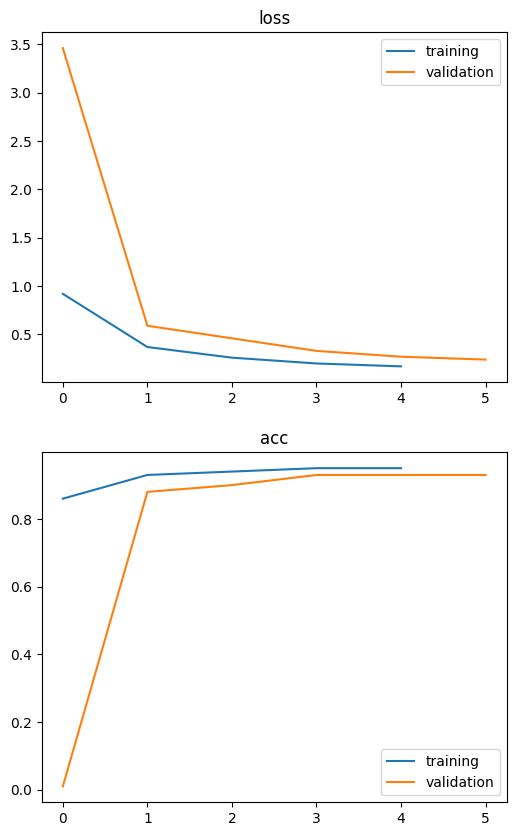

In [21]:
fig, axs = plt.subplots(2, figsize= (6,10))
# loss
axs[0].plot([round(float(entry['train_loss']), 2) for entry in net.train_metrics], label = 'training')
axs[0].plot([round(float(entry['val_loss']), 2) for entry in net.val_metrics], label = 'validation')
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot([round(float(entry['train_acc']), 2) for entry in net.train_metrics], label = 'training')
axs[1].plot([round(float(entry['val_acc']), 2) for entry in net.val_metrics], label = 'validation')
axs[1].set_title("acc")
axs[1].legend()

In [22]:
from typing import NewType
print(f"Best model saved at: {checkpoint_callback.best_model_path}")

best_model_path = checkpoint_callback.best_model_path
model = deeplabv3.load_from_checkpoint(best_model_path).to(device)

# Use the best model for inference
model.eval()
model.freeze()

Best model saved at: /content/lightning_logs/version_1/checkpoints/best-acc-epoch=04-val_acc=0.9337.ckpt


## Evaluation

In [23]:
import gc
with torch.no_grad():
  torch.cuda.empty_cache()
gc.collect()

120

In [24]:
model.eval()
accuracy = []
with torch.no_grad():
    for sample in tqdm(test_loader):
        if sample['image'].shape[0]==1:
            break
        inputs = sample['image'].to(device)
        masks = sample['mask'].to(device)

        outputs = model(inputs)
        y_pred = outputs['out']
        y_true = masks
        # acc using pixel accuracy. (it is easy to understand,but not the best metric)
        acc = (torch.argmax(y_pred, 1) == y_true).float().mean()
        accuracy.append(acc)
accuracy = torch.mean(torch.Tensor(accuracy))
print(f'accuracy: {accuracy}')

  0%|          | 0/8 [00:00<?, ?it/s]

accuracy: 0.9164000749588013


** **BUT** we should not use accuracy on segmentation task, we use **IoU** (Intersection over Union). learn more https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2 <br>
https://www.geeksforgeeks.org/what-are-different-evaluation-metrics-used-to-evaluate-image-segmentation-models/

In [25]:
def compute_iou_batch(predictions, ground_truths, num_classes):
    """
    Compute Intersection over Union (IoU) for semantic segmentation over a batch of images.

    Parameters:
    - predictions: A 4D torch tensor of shape (batch, class, height, width) with predicted class scores
    - ground_truths: A 3D torch tensor of shape (batch, height, width) with ground truth class labels
    - num_classes: Total number of classes in the segmentation task

    Returns:
    - A torch tensor of IoU values for each class
    """
    batch_size = predictions.size(0)
    iou_per_class = torch.zeros(num_classes, dtype=torch.float32)

    # Iterate over each class
    for cls in range(num_classes):
        intersection = 0
        union = 0

        # Compute IoU per image in the batch
        for i in range(batch_size):
            # Predicted mask for the current class
            pred_mask = (predictions[i, cls] > 0.5)  # Apply threshold for binary mask
            # Ground truth mask for the current class
            gt_mask = (ground_truths[i] == cls)

            # Compute Intersection and Union
            intersection += torch.sum(pred_mask & gt_mask).item()
            union += torch.sum(pred_mask | gt_mask).item()

        # Compute IoU for the current class, avoid division by zero
        if union == 0:
            iou_per_class[cls] = float('nan')  # or 0 if you prefer
        else:
            iou_per_class[cls] = intersection / union

    return iou_per_class

In [26]:
num_batches = 0
num_classes = 32
iou_per_class_total = torch.zeros(num_classes, dtype=torch.float32)
model.eval()
with torch.no_grad():
    for sample in tqdm(test_loader):
        if sample['image'].shape[0]==1:
            break
        inputs = sample['image'].to(device)
        masks = sample['mask'].to(device)

        outputs = model(inputs)
        y_pred = outputs['out']
        y_true = masks
        # predictions, ground_truths = batch
        # predictions = torch.softmax(predictions, dim=1)  # Convert logits to probabilities
        batch_iou = compute_iou_batch(y_pred, y_true, num_classes)
        iou_per_class_total += batch_iou
        num_batches += 1

average_iou_per_class = iou_per_class_total / num_batches
overall_average_iou = torch.nanmean(average_iou_per_class)
print(f'average_iou_per_class: {average_iou_per_class}')
print(f'overall_average_iou: {overall_average_iou}')

  0%|          | 0/8 [00:00<?, ?it/s]

average_iou_per_class: tensor([   nan, 0.0000, 0.6595,    nan, 0.7270, 0.0045,    nan, 0.3903, 0.0297,
        0.7489, 0.0631,    nan, 0.0000,    nan, 0.1779,    nan, 0.0212, 0.8938,
           nan, 0.3790, 0.0000, 0.7314,    nan,    nan, 0.4691,    nan, 0.5835,
        0.4388,    nan, 0.0012, 0.0679, 0.5700])
overall_average_iou: 0.33127713203430176


## Visualization

In [27]:
model.eval()
img = next(iter(val_loader))
output = model(img['image'].to(device))['out']

In [28]:
# inverse transform (normalized image -> original)
def invTransform(img):
    img = img*torch.tensor([0.229, 0.224, 0.225]).mean() + torch.tensor([0.485, 0.456, 0.406]).mean()     # unnormalize
    npimg = img.numpy().clip(0,255)
    return npimg

In [29]:
def imshow(img):
    npimg = invTransform(img)
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

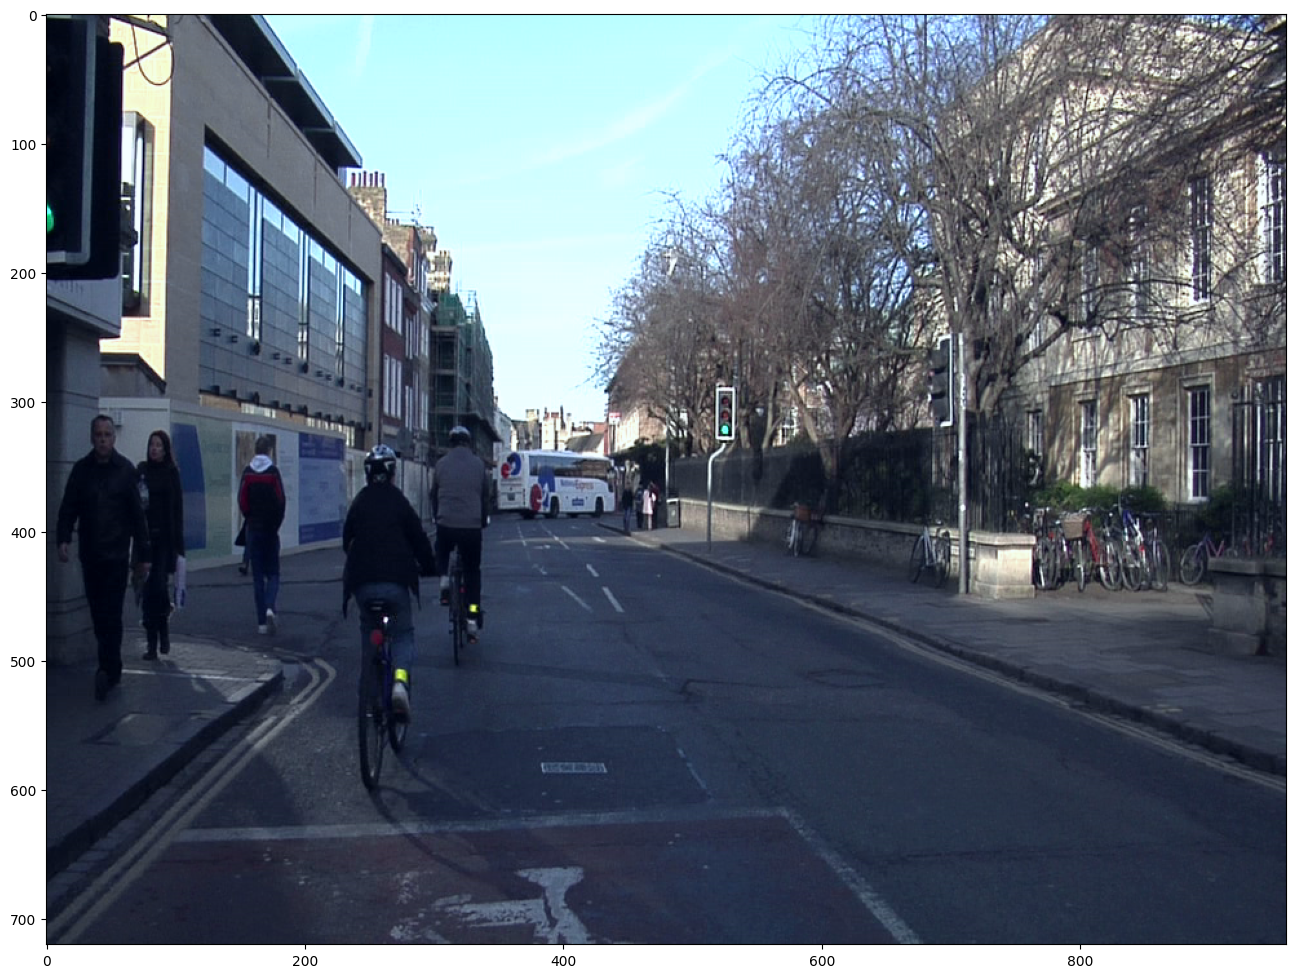

In [30]:
image = img['image'][0]
imshow(image)

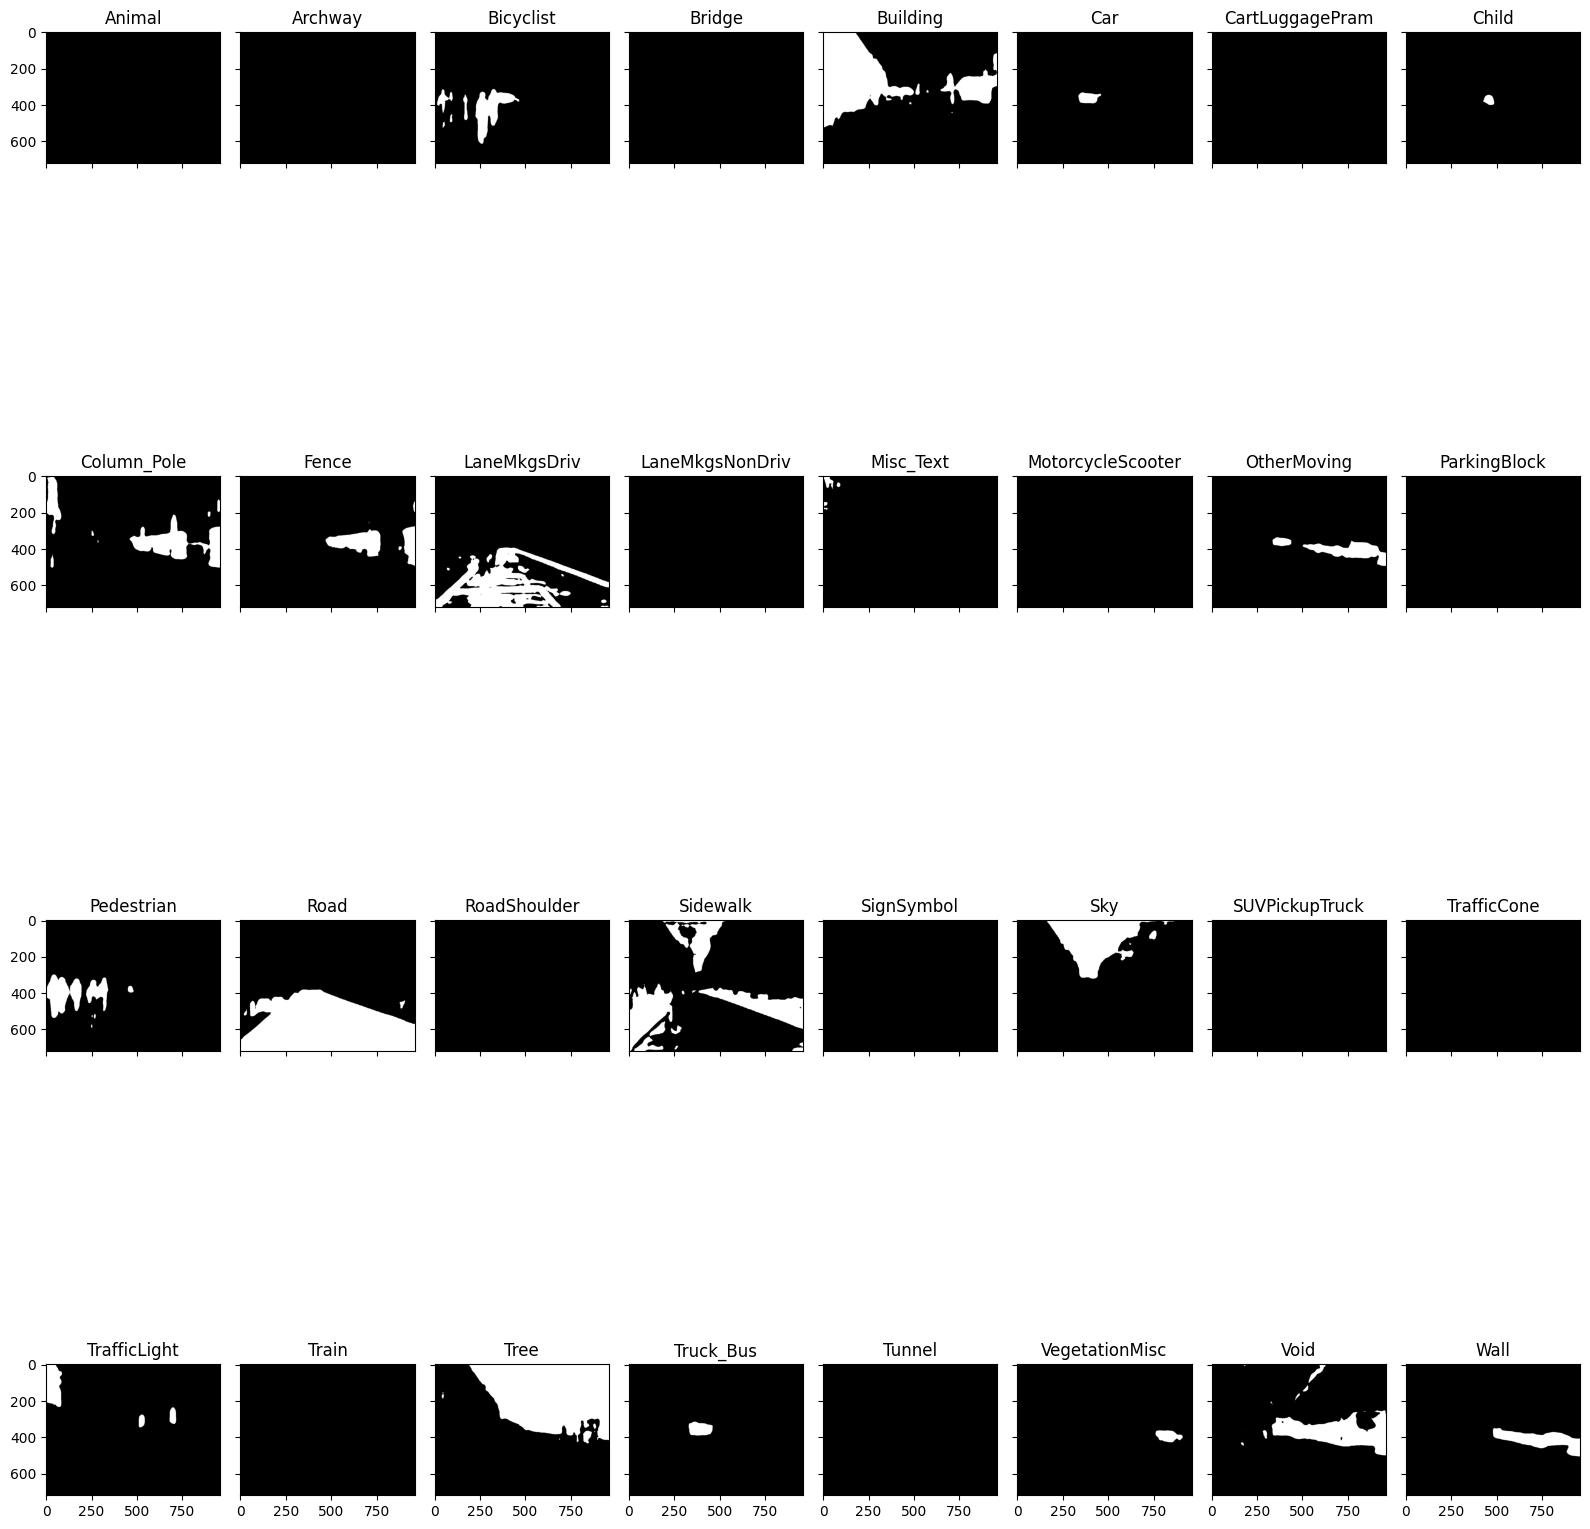

In [31]:
fig, axes = plt.subplots(nrows=4, ncols=8, sharex=True, sharey=True, figsize=(16,20))
axes_list = [item for sublist in axes for item in sublist]

thresh=0.3
res = output[0].detach().cpu().numpy()
for i, mask in enumerate(res):
    ax = axes_list.pop(0)
    ax.imshow(np.where(mask>thresh, 255, 0), cmap='gray')
    ax.set_title(list(colormap.keys())[i])

for ax in axes_list:
    ax.remove()

plt.tight_layout()

In [32]:
res.shape

(32, 720, 960)

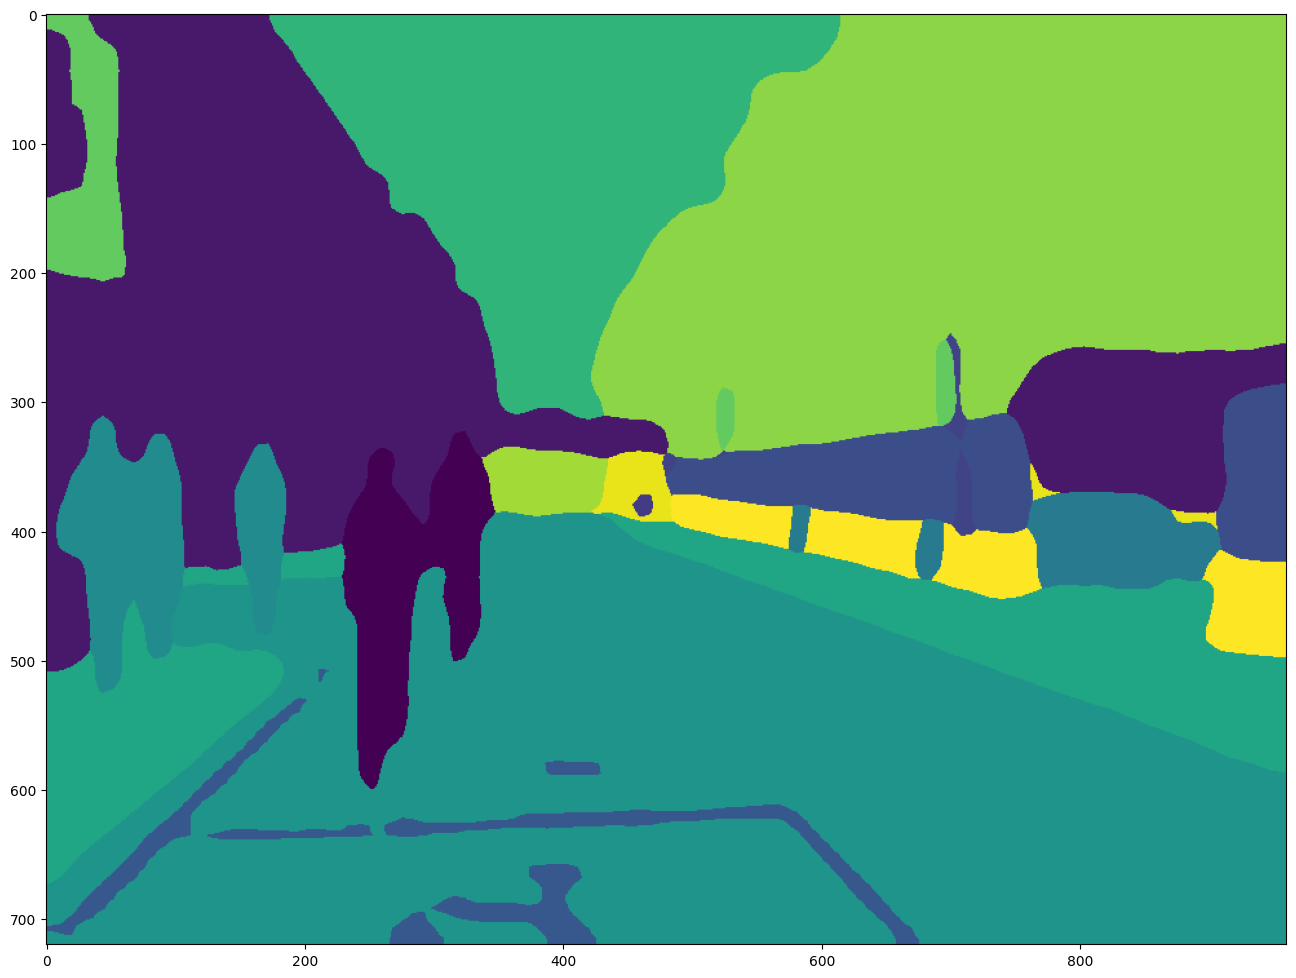

In [33]:
seg = torch.argmax(output[0], 0)
seg = seg.cpu().detach().numpy()
plt.figure(figsize=(16,16))
plt.imshow(seg)  # display image
plt.show()

In [34]:
oiginal_image = invTransform(img['image'][0])
oiginal_image = np.transpose(oiginal_image, (1, 2, 0))

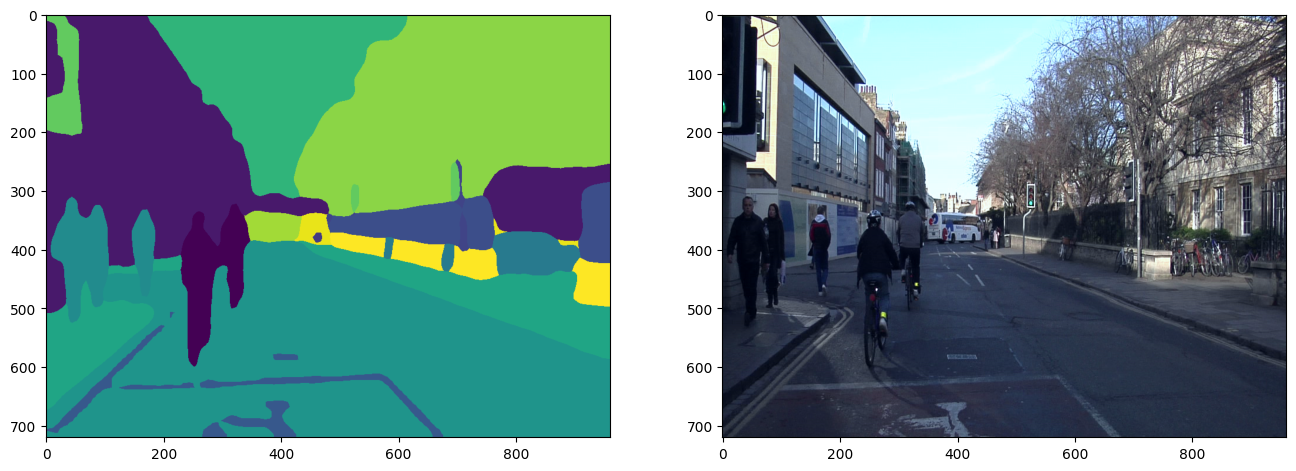

In [35]:
f, axarr = plt.subplots(1,2,figsize= (16,16))
axarr[0].imshow(seg)
axarr[1].imshow(oiginal_image)
plt.show()